## Convolutional Neural Networks in PyTorch

**Contents**
1. Getting data using Torchvision
2. Creating a CNN in PyTorch
3. Training our Network

### Setup and Installations

In [1]:
!pip install numpy pandas torch torchvision pillow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Getting Data with Torchvision

In [2]:
# make a directory to store MNIST images
import os

os.makedirs("./data", exist_ok=True)


In [3]:
from torchvision.datasets import MNIST

train_data = MNIST("./data", train=True, download=True)

In [20]:
# check our data
from PIL import Image
import matplotlib.pyplot as plt

data_item = train_data[0]

img = data_item[0]
target = data_item[1]

img

In [5]:
from pandas import Series

targets = Series([item[1] for item in train_data])

targets.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

### Creating a CNN in PyTorch

We are creating the `LeNet` architecture, which was one of the first proposed convolution neural network architectures. It consists of the following blocks:

- 2 conv blocks: 5x5 Convolution -> ReLU -> 2x2 pooling
- A feedforward classifier: linear layer -> ReLU -> linear layer -> Softmax

**Note:** we will not use batch normalization here, but you can add it after each pooling layer using `nn.BatchNorm2d` in PyTorch

**Overview of Softmax:**

We use softmax when predicting probabilities of different classifiers. The softmax function takes a vector as input and normalizes it such that all values in the vector sum to 1 (which is useful for classification probabilities)

In [6]:
# imports

import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [7]:
# testing softmax
v = torch.rand(5) * 10
v

tensor([0.7945, 9.4883, 1.9454, 1.7363, 7.4249])

In [8]:
# softmax

v_sf = F.softmax(v, dim=-1) # on the last dimension, required for softmax due to updates
v_sf

tensor([1.4858e-04, 8.8640e-01, 4.6964e-04, 3.8104e-04, 1.1260e-01])

In [9]:
torch.sum(v_sf)

tensor(1.0000)

**Building our Network in PyTorch**

To build our network in PyTorch, we're going to need a few building blocks:

- `nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)` - the base convolution operator. The in and out channels determines how deep the model is. We start with three channels (3), but we usually scale to 64/128 channels. LeNet uses a kernel size of 5x5, which requires a padding of 2 to keep the output the same size
- `nn.MaxPool2d(kernel_size, stride)` - the base pooling architecture. Max pooling has shown the best performance of all algorithms. We go across in 2x2 tiles and skip intermediate sections to get information from all sections individually
- `nn.ReLU()` - the relu activation function. We can use this as a module or the function version (`nn.functional.relu()`)
- `nn.Linear(in_dimensions, out_dimensions)` - a linear layer that we will use at the end of the convolution feature extractors
- `nn.Softmax(dimension)` - the softmax function, but as a module instead of the functional version (`nn.functional.softmax()`)

In [36]:
# creating our PyTorch network

class LeNet(nn.Module):
    def __init__(self, n_channels: int, n_classes: int) -> None:
        super().__init__()
        
        # create our first set of convolution layers
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=20, kernel_size=(5, 5)) # 5x5 kernel that takes the input channels and goes to 20 channels
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # the stride allows us to skip intermediates, so we select every unique 2x2 grid
        
        # create our second set of convolution layers
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)) # create more channels for more features to extract
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # create our linear layers for classification
        self.linear1 = nn.Linear(in_features=800, out_features=500) # the number of in_features is calculated based on the flattened output of all images across all 50 channels after processing
        self.linear2 = nn.Linear(in_features=500, out_features=n_classes) # the class predictor
        # self.softmax = nn.Softmax(dim=-1) # -1 selects the last dimension
        
    def forward(self, image: Tensor) -> Tensor:
        # run the first convolution
        out = self.conv1(image)
        out = F.relu(out)
        out = self.pool1(out)
        
        # run the second convolution
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out)
        
        # flatten the set of images in format B x C x H x W
        out = torch.flatten(out, -3, -1)
        
        # run the feedforward network
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        
        return out
        # return self.softmax(out)

### Exploring Our Data

In [19]:
train_data[0][0]

In [14]:
from numpy import asarray

asarray(train_data[0][0]).shape

(28, 28)

In [18]:
asarray(train_data[0][0])[14]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

**Some Notes on our Data Representation:**
- Each input image is 28 by 28 pixels, with a SINGLE channel (no RGB, only black/white)
- We need to create a custom dataloader to batch these images together into *PyTorch* tensors
  - We'll have to convert from `PIL.Image` to `torch.Tensor`
- We also need to scale our data so that the pixel values are between 0 and 1 (makes it easier to traverse)
- We can do this using the `torchvision.transforms` package
  - `torchvision.transforms.ToTensor()` - converts PIL to tensor
  - `torchvision.transforms.Normalizea()` - normalizes our image data
  - `torchvision.transforms.Compose()` - allows us to combine multiple transforms into a single one with optimization

In [22]:
# here is our transform code
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [23]:
# create new datasets from torchvision using the transforms

train_data = MNIST("data", train=True, transform=transform)
test_data = MNIST("data", train=True, transform=transform)

In [24]:
print("train size: ", len(train_data))
print("test size: ", len(test_data))

train size:  60000
test size:  60000


### Training Our Model

**Some things we need to consider:**
- *Loss function:* since this is a classification problem, we will use cross entropy (NOTE: cross entropy runs a softmax function internally, so we don't need to include it in our network)
- *Optimizer:* the Adam optimizer is the standard for image learning, so we will use that
- Some hyperparameters to consider:
  - number of epochs - we will run 10 epochs, but you can play around with this value if you want
  - learning rate - we will use a learning rate of `0.01`
  - batch size - allows us to train multiple samples in parallel. We will train 64 samples at once for high speeds (low this if your computer starts to slow down)

**Validation Data:**
- When we're training, your training loss usually decreases. However, it doesn't mean that your model is getting better
  - Your model could be overoptimizing or overfitting to your training data, or you might have an error in your training loop
- To prevent this, we introduce validation data: every few batches of training data, we evaluate the model on the test set (which it has not seen before)
  - This allows us to see how the model learns a general representation over time, not just memorizing training data
  - In our case, we'll run our validation step after every **epoch is completed**

In [39]:
# let's write our training loop!
from torch.utils.data import DataLoader
from tqdm import tqdm


NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.002

def train(model: LeNet, train_data: MNIST, val_data: MNIST):
    # setup loss function and optimizers
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # setting up lists of losses to save in logs
    train_losses = []
    validation_losses = []
    
    # start our main loop
    for n in range(NUMBER_OF_EPOCHS):
        # create dataloader
        loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        
        
        for index, item in tqdm(enumerate(loader), desc=f"Training epoch {n}", total=len(train_data)//BATCH_SIZE):
            optimizer.zero_grad() # reset optimizer
            inputs, target = item
            
            output = model(inputs)
            
            # compute loss
            loss = loss_function(output, target)
            loss.backward()
            
            train_losses.append(loss.item())
            
            optimizer.step()
        
        # create the validation dataloader
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
        
        # run the validation loop
        with torch.no_grad(): # disables gradient computation, because this is just for evaluation purposes
            losses = []
            for index, item in tqdm(enumerate(val_loader), desc=f"Evaluation epoch {n}", total=len(train_data)//BATCH_SIZE):
                inputs, target = item
                
                output = model(inputs)
                
                # compute loss
                loss = loss_function(output, target)
                losses.append(loss.item())
            
            average_validation_loss = torch.mean(torch.as_tensor(losses)) # take the average of losses across all batches
            validation_losses.append(average_validation_loss.item()) # append to the list of losses to log later
    
    return model, train_losses, validation_losses


In [40]:
# run our training loop

model = LeNet(n_channels=1, n_classes=10)

In [42]:
model, train_loss_out, val_loss_out = train(model, train_data, test_data)

Training epoch 0: 938it [00:16, 57.02it/s]                         
Evaluation epoch 0: 938it [00:10, 93.11it/s]                         
Training epoch 1: 938it [00:16, 56.79it/s]                         
Evaluation epoch 1: 938it [00:10, 92.72it/s]                         
Training epoch 2: 938it [00:16, 56.59it/s]                         
Evaluation epoch 2: 938it [00:10, 92.86it/s]                         
Training epoch 3: 938it [00:16, 56.60it/s]                         
Evaluation epoch 3: 938it [00:10, 92.33it/s]                         
Training epoch 4: 938it [00:16, 56.61it/s]                         
Evaluation epoch 4: 938it [00:10, 92.32it/s]                         
Training epoch 5: 938it [00:16, 57.15it/s]                         
Evaluation epoch 5: 938it [00:10, 92.55it/s]                         
Training epoch 6: 938it [00:16, 56.53it/s]                         
Evaluation epoch 6: 938it [00:10, 91.48it/s]                         
Training epoch 7: 938it [00:16, 57

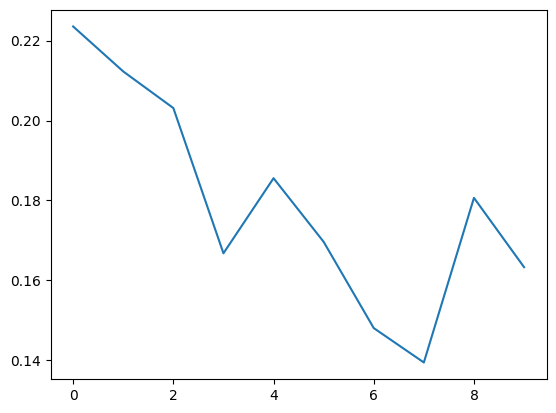

In [44]:
# let's see our loss outputs

plt.plot(val_loss_out)

### Evaluating Our Model

Here, we'll set up a similar evaluation loop and use a confusion matrix and classification report to compare outputs

In [49]:
# The evaluation loop

def predict(model: LeNet, testing_data):
    # create the validation dataloader
    val_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)
    y_pred = []
    
    # run the validation loop
    with torch.no_grad(): # disables gradient computation, because this is just for evaluation purposes
        for index, item in tqdm(enumerate(val_loader), desc=f"Predictions!", total=len(train_data)//BATCH_SIZE):
            inputs, target = item
            output = model(inputs)
            logits = torch.argmax(output, dim=-1).tolist()
            y_pred += logits            
    
    return y_pred

In [50]:
y_pred = predict(model, test_data)

Predictions!: 938it [00:10, 91.43it/s]                         


In [51]:
len(y_pred)

60000

In [52]:
y_target = [item[1] for item in test_data]

In [54]:
len(y_target)

60000

In [57]:
# metrics with sklearn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

<Axes: >

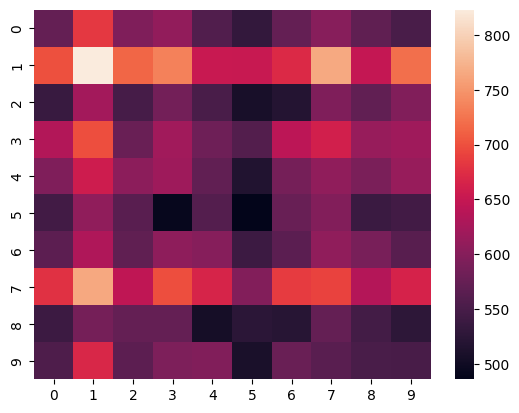

In [58]:
cm = confusion_matrix(y_pred, y_target)
sns.heatmap(cm)

In [59]:
print(classification_report(y_pred, y_target))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10      5844
           1       0.12      0.12      0.12      7082
           2       0.09      0.10      0.09      5632
           3       0.10      0.10      0.10      6206
           4       0.10      0.10      0.10      5958
           5       0.09      0.09      0.09      5512
           6       0.10      0.10      0.10      5840
           7       0.11      0.10      0.11      6726
           8       0.09      0.10      0.10      5469
           9       0.09      0.10      0.09      5731

    accuracy                           0.10     60000
   macro avg       0.10      0.10      0.10     60000
weighted avg       0.10      0.10      0.10     60000

